In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os,sys,time
import numpy as np
import pandas as pd
import pymaster as nmt
import healpy as hp
import healpy.newvisufunc as hpn
import astropy.io.fits as fits
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from   IPython.display import clear_output
from matplotlib import cm
from matplotlib import rc
from copy import deepcopy as dcopy
rc('text', usetex=True)
font = {'weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)

import astropy.units as u
import random

In [2]:
nside  = 256
npix   = 12*nside**2
nu_min = 980  #Mhz
nu_max = 1260 #Mhz
nch    = 30
nbeams = 28       #number of beams# here it is the number of feed horns
Tsys   = 70       #system temperatyre in K
Osur   = 5324     #Full survey area           # sqr deg
Obeam  = 0.35     #Telescope beam solid angle # sqr deg
tsur   = 1        #Mission duration # yrs
K      = 2**(1/2) #two circ polarization contribution: (I-V) and (I+V)
fsky   = 0.13
dcycle = 0.9

t_unit      = 24*60*60
tsur       *= 365*t_unit #yr to sec
tsur       *= dcycle
nu_max     *= 1e6
nu_min     *= 1e6

bandwidth   = (nu_max-nu_min)/nch
N           = Osur/Obeam #number of pixels in the map
tpix        = (tsur/N)*nbeams
Snoise = K*Tsys/np.sqrt(tpix*bandwidth)
Spix   = Snoise*np.sqrt(fsky*npix/nbeams/tsur) 
#print("tpix {:.2f} sec".format(tpix))
print("tpix: {:.2f} hour/pix".format(tpix/3600),"\n")

#print("sigmaN: {:.8f} K".format(Snoise))
print("sigmaN: {:.2f} mK".format(Snoise*1e6),"\n")

#print("sigma pix: {:.8f} K".format(Spix))
print("sigma pix: {:.2f} mK/pix".format(Spix*1e6),"\n")

tpix: 14.51 hour/pix 

sigmaN: 141.77 mK 

sigma pix: 1.61 mK/pix 



In [3]:
Snoise

0.00014176730284987753

In [4]:
#sigmaN = Snoise*1e6*u.Unit("mK")
sigmaN = Spix*1e6*u.Unit("mK")
random.seed(9001)
wn = np.random.normal(scale = sigmaN.value, size=npix) * sigmaN.unit

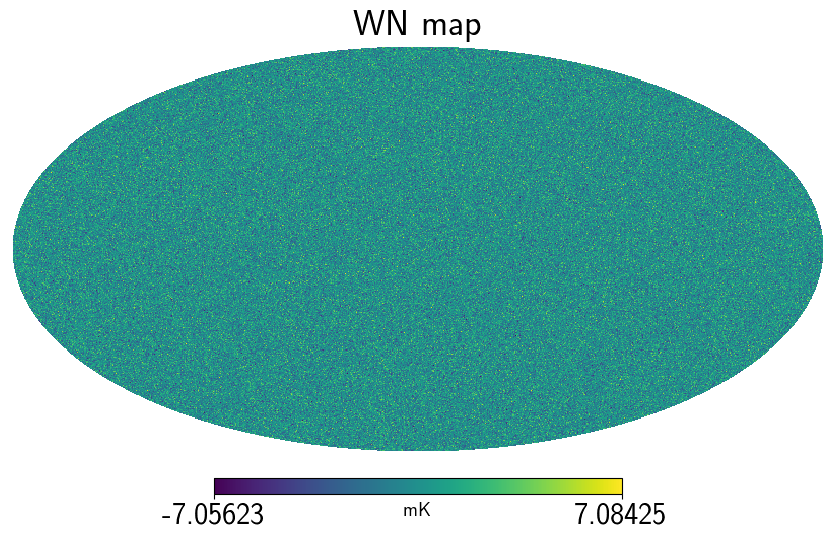

In [5]:
hp.mollview(wn, unit=wn.unit, title="WN map")

In [6]:
np.random.seed(9001)
np.random.normal(scale=1, size=10)

array([ 0.20074512,  0.85937284,  1.5794691 ,  0.01235437, -0.04828399,
        0.82692073,  0.83020895,  0.62318445, -0.16268287, -0.03335389])

In [7]:
np.random.seed(9001)
np.random.normal(scale=1, size=10)

array([ 0.20074512,  0.85937284,  1.5794691 ,  0.01235437, -0.04828399,
        0.82692073,  0.83020895,  0.62318445, -0.16268287, -0.03335389])

### -------
##### Testing with Simons Obs hitmap data

https://www.zonca.dev/posts/2020-06-21-white-noise-hitmap-not-uniform

In [9]:
#Simons Observatory hitmap data
#hitmap_url = "https://portal.nersc.gov/project/sobs/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz"

In [10]:
#!wget $hitmap_url

In [11]:
hitmap = hp.read_map("ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz")

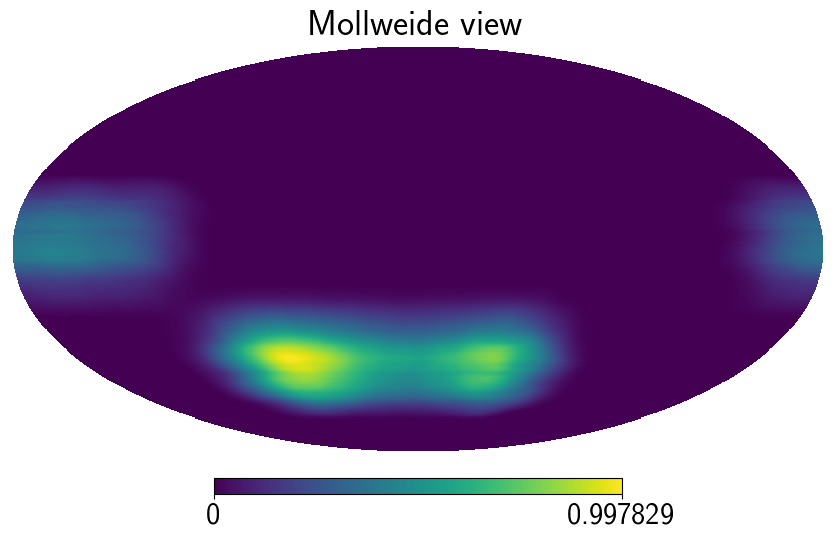

In [12]:
hitmap = hitmap / hitmap.max()
hp.mollview(hitmap)

In [13]:
hp.get_nside(hitmap)

512

In [14]:
hitmap = hp.read_map("ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz")
hitmap = hitmap / hitmap.max()
integration_time_total = 5 * u.year * dcycle
#eh como se, dentro dos 5 anos de observação, 
#certos pixels teve uma percentagem de observacao dada pelo hitmap normlaizado
hitmap = hitmap * integration_time_total.to(u.s) #convert from year to (s)ec

hitmap_plot = hitmap.value.copy()
hitmap_plot[hitmap == 0] = hp.UNSEEN

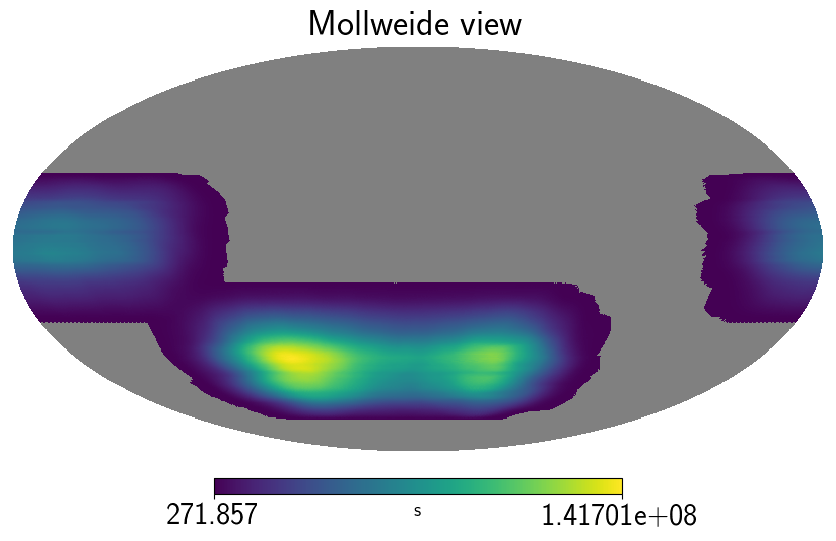

In [15]:
hp.mollview(hitmap_plot, unit=hitmap.unit);

In [107]:
hitmap

array([0., 0., 0., ..., 0., 0., 0.])

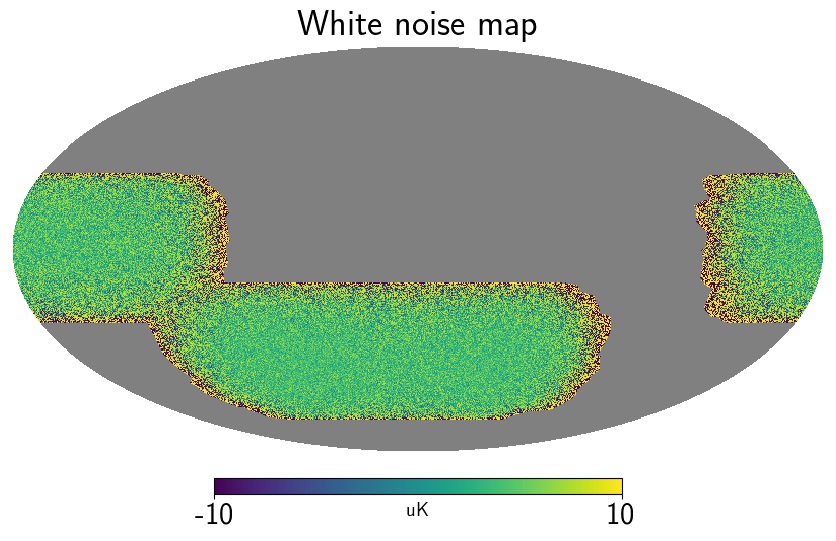

In [16]:
net = 10. * u.Unit("uK * sqrt(s)")
variance_per_pixel = (net**2 / hitmap).decompose() #decompose em unidades estabelecidas. Provavel que aqui seja as SI
variance_per_pixel[np.isinf(variance_per_pixel)] = 0
m = np.random.normal(scale = np.sqrt(variance_per_pixel),
                     size=len(variance_per_pixel)) * np.sqrt(variance_per_pixel).unit
m.value[hitmap==0] = hp.UNSEEN
m = m.to(u.uK)
m.value[hitmap==0] = hp.UNSEEN
hp.mollview(m, unit=m.unit, min=-10, max=10, title="White noise map", norm='hist')

In [17]:
# sigma^weighted_noise(t^eff_obs) = kappa * sigma^uniform_noise(t^eff_obs)
# 1/kappa^2 = (hitmap/max(hitmap))*(t^eff_obs/t_pix)

In [8]:
def getmaps_simple(pathmaps, mapsname):
    pathmaps = os.path.join(pathmaps, mapsname)
    with fits.open(pathmaps) as h:
        maps = h[0].data
    return maps

In [9]:
dir_mask   = "/media/BINGODATA1/ComponentSeparation/MAPS/HS"
name_mask  = "hitmap_140Horns_1Month.fits"
hitmap     = getmaps_simple(pathmaps=dir_mask,
                            mapsname=name_mask)
hitnorm = hitmap/hitmap.max()

In [10]:
hp.get_nside(hitmap)

128

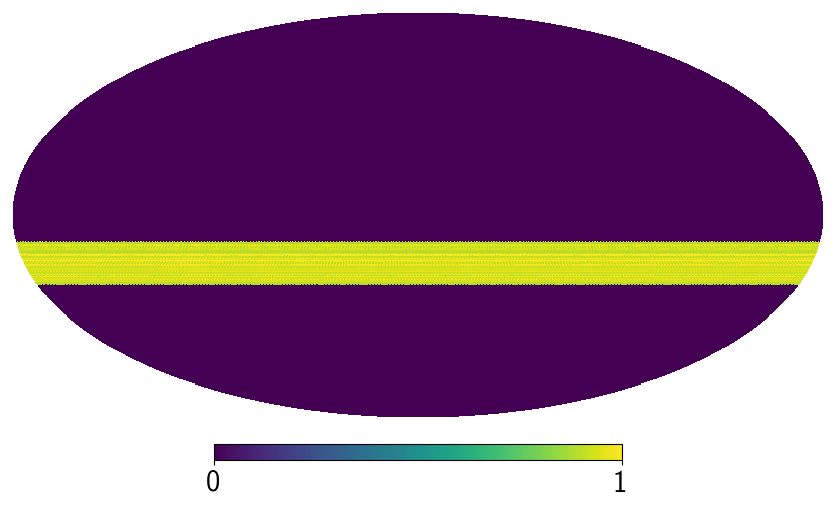

In [27]:
hitnorm = hitmap/hitmap.max()
hp.mollview(hitnorm,cmap = 'viridis', norm='hist', title=None)


<Figure size 2000x800 with 0 Axes>

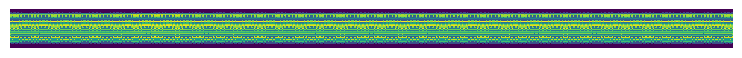

In [41]:
dec_min = -25.48
dec_max = -10.17
Dec_min = dec_min - 2
Dec_max = dec_max + 2
CMAP    = "viridis"
plt.figure(figsize=(20,8))
hp.cartview(hitnorm, norm="hist",  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, max=1, min=0,cbar=None,xsize=1200)

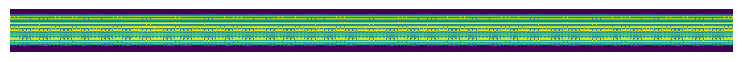

In [106]:
Dec_min = dec_min - 3
Dec_max = dec_max + 3
hitnorm512 = hp.ud_grade(hitnorm,512)
hp.cartview(hitnorm512, norm="hist",  latra=[Dec_min,Dec_max], cmap=CMAP, title=None, max=1, min=0,cbar=None,xsize=1200)

In [56]:
kappa2 = 1/ (hitnorm*(tsur/tpix))
kappa2

array([inf, inf, inf, ..., inf, inf, inf])

In [69]:
ind0=np.where(kappa2==np.inf)[0]
kappa2[ind0]=0
kappa=np.sqrt(kappa2)
kappa

array([0., 0., 0., ..., 0., 0., 0.])

In [86]:
sigmaN = Snoise*1e6#*u.Unit("uK")
random.seed(9001)
wn = np.random.normal(scale = sigmaN, size=hp.nside2npix(128))
wn_weighted = dcopy(kappa*wn)
ind0 = np.where(wn_weighted==0)[0]
wn_weighted[ind0]=hp.UNSEEN

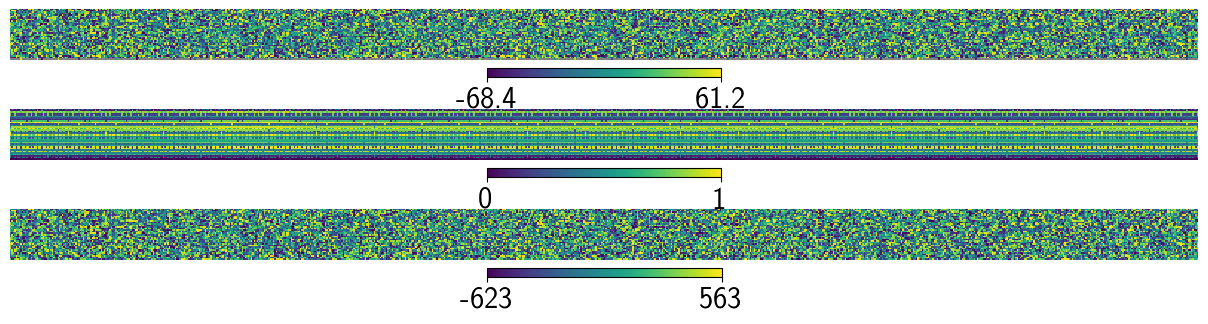

In [92]:
plt.figure(figsize=(12,3))

Dec_min = dec_min - 0.1
Dec_max = dec_max + 0.1
CMAP    = "viridis"
hp.cartview(wn_weighted , 
            norm="hist", unit=None,  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title=None,
            sub=311)

hp.cartview(hitnorm, 
            norm="hist", unit=None,  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title=None,
            sub=312)

hp.cartview(wn, 
            norm="hist", unit=None,  
            latra=[Dec_min,Dec_max], 
            cmap=CMAP, title=None,
            sub=313)

In [27]:
nside  = 256
npix   = 12*nside**2
nu_min = 960  #Mhz
nu_max = 1260 #Mhz
nch    = 30
nbeams = 28       #number of beams# here it is the number of feed horns
Tsys   = 70       #system temperatyre in K
Osur   = 5324     #Full survey area           # sqr deg
Obeam  = 0.35     #Telescope beam solid angle # sqr deg
tsur   = 1        #Mission duration # yrs
K      = 2**(1/2) #two circ polarization contribution: (I-V) and (I+V)
fsky   = 0.13
dcycle = 1#0.9

t_unit      = 24*60*60
tsur       *= 365*t_unit #yr to sec
tsur       *= dcycle
nu_max     *= 1e6
nu_min     *= 1e6

bandwidth   = (nu_max-nu_min)/nch
N           = Osur/Obeam #number of pixels in the map
tpix        = (tsur/N)*nbeams
Snoise = K*Tsys/np.sqrt(tpix*bandwidth)
Spix   = Snoise*np.sqrt(fsky*npix/nbeams/tsur) 
#print("tpix {:.2f} sec".format(tpix))
print("tpix: {:.2f} hour/pix".format(tpix/3600),"\n")

#print("sigmaN: {:.8f} K".format(Snoise))
print("sigmaN: {:.2f} mK".format(Snoise*1e6),"\n")

#print("sigma pix: {:.8f} K".format(Spix))
print("sigma pix: {:.2f} mK/pix".format(Spix*1e6),"\n")

tpix: 16.12 hour/pix 

sigmaN: 129.93 mK 

sigma pix: 1.40 mK/pix 



In [28]:
#sigmaN = Snoise*1e6*u.Unit("mK")
sigmaN = Spix*1e6
np.random.seed(100)
wn = np.random.normal(scale = sigmaN, size=npix)
wn.min(),wn.max()

(-6.77760265489396, 7.386961333072781)

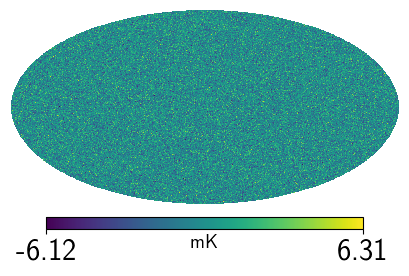

In [29]:
#siud_gradeN = Snoise*1e6*u.Unit("mK")
sigmaN = Spix*1e6*u.Unit("mK")
random.seed(9001)
wn = np.random.normal(scale = sigmaN.value, size=npix) * sigmaN.unit
hp.mollview(wn.value, unit=wn.unit, title=None, format='%.2f', sub=211)
#hp.mollview(hp.ud_grade(wn.value,256), unit=wn.unit, title=None, format='%.2f', sub=212)
#plt.savefig("/home/amarins/wn.jpg", dpi=100, bbox_inches='tight')

In [30]:
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation//beam_analyzes/scripts')
import handling_data          as hdata
dirM   = '/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/M256'
pathM  = 'mask_256_apodcutless.fits'
mask   = hdata.getmap(dirpath_ = dirM,filename_= pathM, 
                      healpix_readingformat=False, hdu=1)

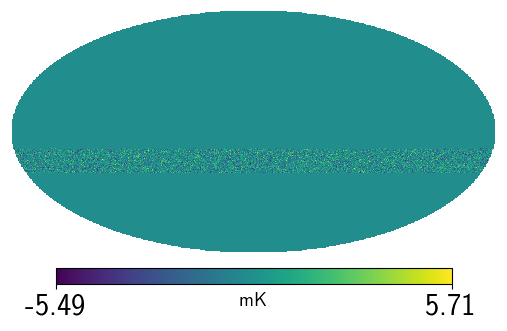

In [31]:
plt.figure(figsize=(8,6))
#siud_gradeN = Snoise*1e6*u.Unit("mK")
sigmaN = Spix*1e6*u.Unit("mK")
random.seed(9001)
wn = np.random.normal(scale = sigmaN.value, size=npix) * sigmaN.unit
hp.mollview(wn.value*mask, unit=wn.unit, title=None, format='%.2f', sub=211)
#hp.mollview(hp.ud_grade(wn.value,256), unit=wn.unit, title=None, format='%.2f', sub=212)
#plt.savefig("/home/amarins/wn.jpg", dpi=100, bbox_inches='tight')

In [111]:
dir_mask   = "/media/BINGODATA1/ComponentSeparation/MAPS/HS"
name_mask  = "hitmap_140Horns_1Month.fits"
hitmap     = getmaps_simple(pathmaps=dir_mask,
                            mapsname=name_mask)
hitnorm    = hitmap/hitmap.max()
hitnorm256 = hp.ud_grade(hitnorm,256)

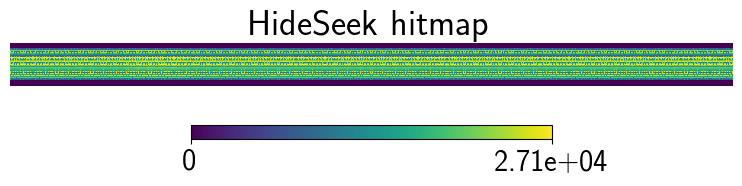

In [112]:
CMAP = 'viridis'
dec_min = -25.48
dec_max = -10.17
Dec_min = dec_min - 3
Dec_max = dec_max + 3
#hp.cartview(hitnorm256, norm="hist",  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,sub=211)
hp.cartview(hitmap   , norm="hist",  title='HideSeek hitmap',latra=[Dec_min,Dec_max], cmap=CMAP)
plt.savefig("/home/amarins/hitmap.jpg", dpi=100, bbox_inches='tight')

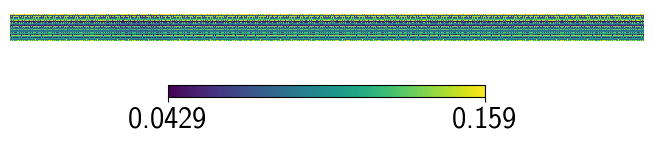

In [113]:
kappa = hitnorm256*(tsur/tpix)
kappa = 1/kappa
hp.cartview(np.sqrt(kappa), norm="hist",  latra=[Dec_min,Dec_max], cmap=CMAP, title=None,sub=111)

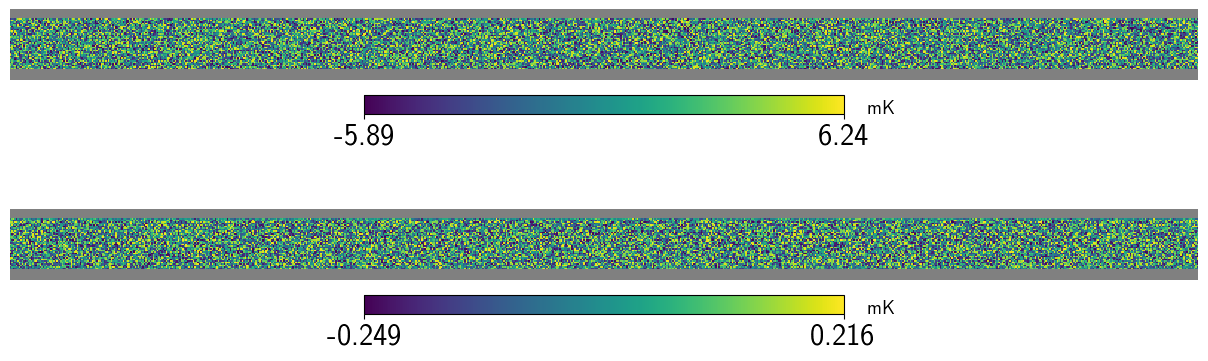

In [114]:
net        = Spix*1e6*np.sqrt(tpix)
hitnorm    = hitmap/hitmap.max()
hitnorm256 = hp.ud_grade(hitnorm,nside)


var_per_pix = net**2/(1/hitnorm256*tsur)
var_per_pix[np.isinf(var_per_pix)]=0


random.seed(9001)
m = np.random.normal(scale = np.sqrt(var_per_pix), size=len(var_per_pix))
m[hitnorm256==0] = hp.UNSEEN

sigmaN = Spix*1e6*u.Unit("mK")
random.seed(9001)
wn = np.random.normal(scale = sigmaN.value, size=len(var_per_pix)) * sigmaN.unit
WN = dcopy(wn.value)
WN[hitnorm256==0] = hp.UNSEEN

Dec_min = dec_min - 3
Dec_max = dec_max + 3
plt.figure(figsize=(12,4))
hp.cartview(WN, norm="hist",  unit='mK',latra=[Dec_min,Dec_max], title=None,sub=211)
hp.cartview(m,  norm="hist",  unit='mK',latra=[Dec_min,Dec_max], title=None,sub=212)
#plt.savefig("/home/amarins/weighted_wn.jpg", dpi=100, bbox_inches='tight')

In [115]:
m      = hitnorm256
pix    = np.where(m!=0)[0]
ra,dec = hp.pix2ang(hp.get_nside(m), lonlat=True, ipix=pix)
dec.min(), dec.max()

(-25.447729744851912, -9.745426482773624)

In [ ]:
moon cake autumn chinese party